# Generator level analysis of $W\rightarrow\mu\nu$ events in HGCAL acceptance 

Date: 27/05/2022

Author: P. Silva (psilva@cern.ch)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ROOT
import PyRDF
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])   

Welcome to JupyROOT 6.24/06


In [2]:
#prepare outputs
_outdir='/eos/user/p/psilva/data/wanalysis/'
os.system('mkdir -p {}/Chunks'.format(_outdir))
_plotsdir='/eos/user/p/psilva/www/wanalysis/{}'.format(datetime.datetime.now().strftime('%Y%b%d'))
os.system('mkdir -p {}'.format(_plotsdir))

#build file list
indir='/eos/cms/store/cmst3/group/top/psilva/WtoMuNu_pythia8_TuneCP5_14TeV/'
file_list=[]
for f in os.listdir(indir):
    if not '.root' in f : continue
    file_list.append( os.path.join(indir,f) )
print(f'Found {len(file_list)} files')

Found 5 files


## Selection

In [3]:
def select(file_list,local=True,debug=True):
    
    """
    select the events and returns the result as a pandas DataFrame
    local: use multithread instead of spark
    debug: enable printouts
    """
    if local:
        ROOT.ROOT.EnableImplicitMT()
        PyRDF.use('local')
    else:
        PyRDF.use('spark', {'npartitions':20})
        file_list = ['root://eosuser.cern.ch/{}'.format(f) for f in file_list]
        
    #define the selections and branches with an RDataFrame
    rdf=PyRDF.RDataFrame("Events", file_list)
    
    totalWeights = rdf.Sum('Generator_weight').GetValue()
        
    #charged lepton selection (trigger) - require at least one
    l_cuts = 'GenDressedLepton_pt>10 && abs(GenDressedLepton_eta)<4.7 && abs(GenDressedLepton_pdgId)==13'
    rdf = rdf.Define("good_lep", l_cuts) \
             .Define('n_good_lep','ROOT::VecOps::Sum(good_lep)') \
             .Filter('n_good_lep==1') \
             .Define('l_pt',  'GenDressedLepton_pt[good_lep][0]') \
             .Define('l_phi', 'GenDressedLepton_phi[good_lep][0]') \
             .Define('l_eta', 'GenDressedLepton_eta[good_lep][0]') \
    
    #save snapshot with interesting branches
    branch_names_list= ['Generator_weight','event', 'l_pt',  'l_eta',  'l_phi']
    branchList = ROOT.vector('string')()
    for branchName in branch_names_list: branchList.push_back(branchName)
    rdf.Snapshot('Events', 
                 f'{_outdir}/Chunks/wjets_14tev.root',
                 branchList)
    
    #disable the implicit multi-threading if it has been used
    if local:
        ROOT.ROOT.DisableImplicitMT()
        
    return totalWeights
    
_sumWeights=select(file_list,local=True)
print('Initial sum of weights:',_sumWeights)

Initial sum of weights: 50000.0


Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/cvmfs/sft.cern.ch/lcg/releases/spark/3.1.2-cern1-43473/x86_64-centos7-gcc8-opt/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/cvmfs/sft.cern.ch/lcg/releases/hadoop/3.3.0-04a04/x86_64-centos7-gcc8-opt/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2022-05-30 10:03:36,658 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Warning in <TClass::Init>: no

## Plotting

If the selection has been already perfomed you can start here

In [15]:
_xsec=18.95e+3 #pb
_instlumi=5e34 #cm-2 s-1

_xsec=_xsec*1e-36  # cm2
_lumi=_instlumi*60*60  #cm-2 / hour


_sumGenerator_weight=50000.0 #update this if you run the previous cell

rdf=ROOT.RDataFrame('Events',f'/eos/user/p/psilva/data/wanalysis/Chunks/wjets_14tev.root')
df=pd.DataFrame(rdf.AsNumpy())
df['wgt']=df['Generator_weight']*_xsec*_lumi/_sumGenerator_weight
df.describe()

Generator_weight         event          l_pt         l_eta  \
count           46625.0  46625.000000  46625.000000  46625.000000   
mean                1.0   4997.715110     32.858036      0.020568   
std                 0.0   2884.484016     13.161414      2.197379   
min                 1.0      1.000000     10.000965     -4.698242   
25%                 1.0   2500.000000     24.566359     -1.735596   
50%                 1.0   4996.000000     32.859024      0.037369   
75%                 1.0   7497.000000     39.056900      1.771484   
max                 1.0  10000.000000    318.847473      4.699219   

              l_phi           wgt  
count  46625.000000  4.662500e+04  
mean       0.005609  6.822000e+01  
std        1.811583  1.421101e-14  
min       -3.141602  6.822000e+01  
25%       -1.556152  6.822000e+01  
50%        0.000090  6.822000e+01  
75%        1.576172  6.822000e+01  
max        3.141602  6.822000e+01

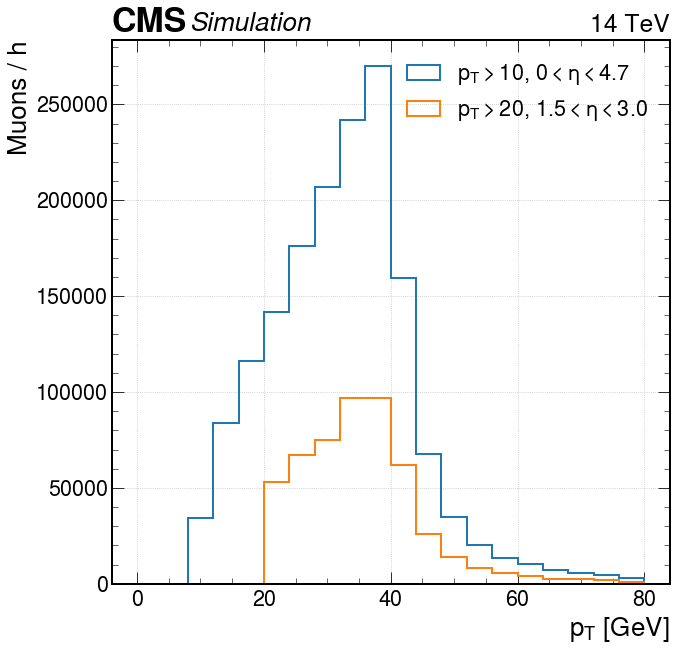

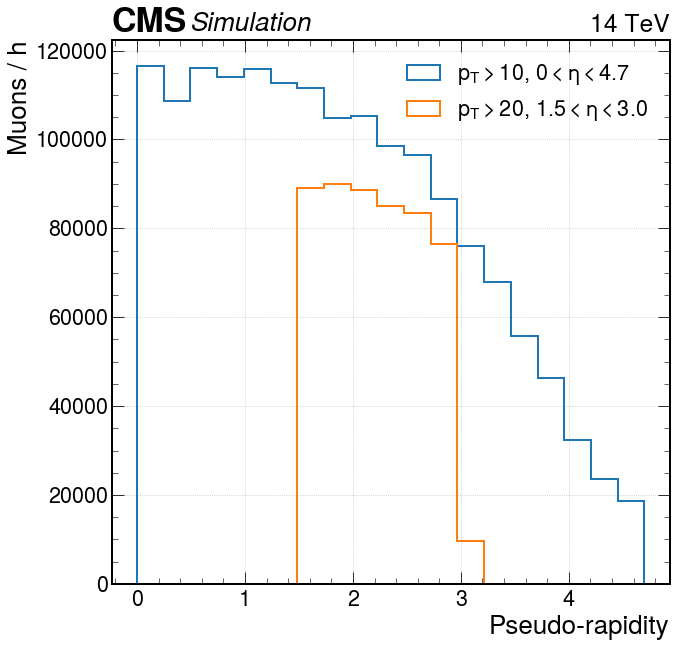

In [16]:
mask_pos=(df['l_pt']>10) & (df['l_eta']>0) & (df['l_eta']<4.7)
mask_hgc=(df['l_pt']>20) & (df['l_eta']<3) & (df['l_eta']>1.5)

bins=np.linspace(0,80,21)
kwargs={'bins':bins,'histtype':'step','linewidth':2}
plt.hist(df[mask_pos]['l_pt'],weights=df[mask_pos]['wgt'],label='$p_{T}>10$, $0<\eta<4.7$',**kwargs)
plt.hist(df[mask_hgc]['l_pt'],weights=df[mask_hgc]['wgt'],label='$p_{T}>20$, $1.5<\eta<3.0$',**kwargs)
plt.legend()
plt.grid()
plt.ylabel('Muons / h')
plt.xlabel(r'$p_{T}$ [GeV]')
hep.cms.label(loc=0,data=False,rlabel='14 TeV')
plt.show()

kwargs={'bins':np.linspace(0,4.7,20),'histtype':'step','linewidth':2}
plt.hist(df[mask_pos]['l_eta'],weights=df[mask_pos]['wgt'],label='$p_{T}>10$, $0<\eta<4.7$',**kwargs)
plt.hist(df[mask_hgc]['l_eta'],weights=df[mask_hgc]['wgt'], label='$p_{T}>20$, $1.5<\eta<3.0$',**kwargs)
plt.legend()
plt.grid()
plt.ylabel('Muons / h')
plt.xlabel(r'Pseudo-rapidity')
hep.cms.label(loc=0,data=False,rlabel='14 TeV')
plt.show()

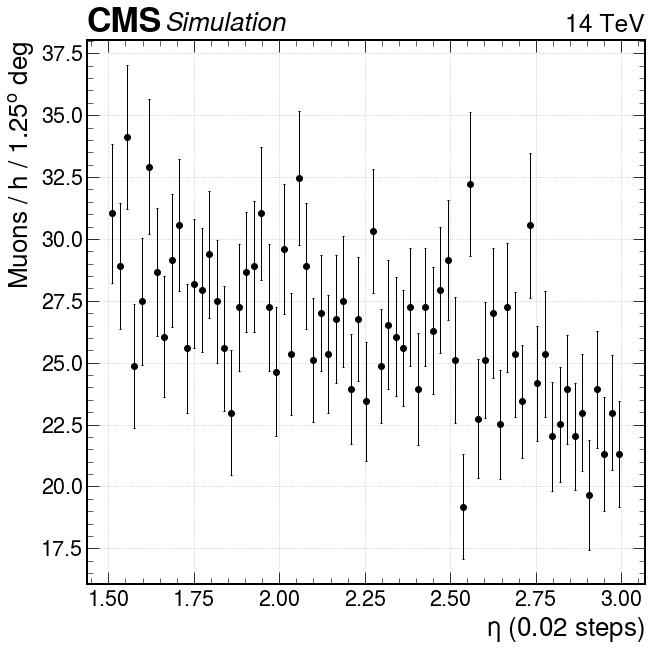

In [48]:
deta=np.radians(1.25)
x,y,ey=[],[],[]
for eta in np.arange(1.5,3,deta):
    mask=(df['l_eta']>=eta) & (df['l_eta']<eta+deta) & (df['l_pt']>20)
    cts=np.histogram(df[mask]['l_phi'],weights=df[mask]['wgt'],bins=np.linspace(-np.pi,np.pi,289))[0]
    
    x.append(eta+0.5*deta)
    y.append(cts.mean())
    ey.append(cts.std()/np.sqrt(288))
    
ebar_style={'marker':'o','elinewidth':1,'capsize':1,'color':'k','ls':'none'}
plt.errorbar(x,y,yerr=ey,**ebar_style)
plt.grid()
plt.ylabel(r'Muons / h / 1.25$^o$ deg')
plt.xlabel(r'$\eta$ (%3.2f steps)'%deta)
hep.cms.label(loc=0,data=False,rlabel='14 TeV')
plt.show()


In [41]:
bins=np.linspace(-np.pi,np.pi,289)
np.degrees(bins[1]-bins[0])

1.2499999999999987